In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings

warnings.filterwarnings("ignore")

SEED = 42

In [2]:
import torch
import pickle
import pandas as pd

In [3]:
print(f"pytorch version: {torch.__version__}")
print(f"cuda available: {torch.cuda.is_available()}")
print(f"devices count: {torch.cuda.device_count()}")

pytorch version: 2.1.2+cu118
cuda available: True
devices count: 4


In [4]:
embedders = [
    {'model': 'intfloat/multilingual-e5-base', 'model_ident': 'me5-base'},
    {'model': 'intfloat/multilingual-e5-large', 'model_ident': 'me5-large'},
    {'model': 'deutsche-telekom/gbert-large-paraphrase-cosine', 'model_ident': 't-gbert-lpc'}
]

classifiers = ['svc', 'rfc', 'mlp']

annotators = ["A001", "A002", "A003", "A004", "A005", "A007", "A008", "A009", "A010", "A012"]

In [5]:
def output_st2(predictions):

    QUANT_TO_QUAL={0: 0, 1: 1, 2: 1, 3: 1, 4: 1}
    
    predictions_qual: pd.DataFrame = predictions.applymap(lambda x: QUANT_TO_QUAL[x] if not pd.isna(x) else x)
    
    output_st2 = pd.DataFrame(index=["id"])
    output_st2.index = predictions.index
    
    output_st2["id"] = predictions.index
    output_st2["dist_bin_0"] = predictions_qual.apply(lambda x: (x == 0).sum() / x.count(), axis='columns')
    output_st2["dist_bin_1"] = predictions_qual.apply(lambda x: (x == 1).sum() / x.count(), axis='columns')
    output_st2["dist_multi_0"] = predictions.apply(lambda x: (x == 0).sum() / x.count(), axis='columns')
    output_st2["dist_multi_1"] = predictions.apply(lambda x: (x == 1).sum() / x.count(), axis='columns')
    output_st2["dist_multi_2"] = predictions.apply(lambda x: (x == 2).sum() / x.count(), axis='columns')
    output_st2["dist_multi_3"] = predictions.apply(lambda x: (x == 3).sum() / x.count(), axis='columns')
    output_st2["dist_multi_4"] = predictions.apply(lambda x: (x == 4).sum() / x.count(), axis='columns')
    
    return output_st2

In [6]:
from scipy.spatial import distance

def score_st2(correct, prediction):
    score = 0
    for idx, correct_row in correct.iterrows():
        prediction_row = prediction.loc[idx]
        correct_vector_bin = [correct_row["dist_bin_0"], correct_row["dist_bin_1"]]
        prediction_vector_bin = [prediction_row["dist_bin_0"], prediction_row["dist_bin_1"]]
        correct_vector_multi = [correct_row["dist_multi_0"], correct_row["dist_multi_1"], correct_row["dist_multi_2"], correct_row["dist_multi_3"], correct_row["dist_multi_4"]]
        prediction_vector_multi = [prediction_row["dist_multi_0"], prediction_row["dist_multi_1"], prediction_row["dist_multi_2"], prediction_row["dist_multi_3"], prediction_row["dist_multi_4"]]

        distance_bin = distance.jensenshannon(correct_vector_bin, prediction_vector_bin)
        distance_multi = distance.jensenshannon(correct_vector_multi, prediction_vector_multi)
        score += (distance_bin + distance_multi) / 2
    return score / len(correct) 

In [7]:
y_val = pd.read_json("created_data/training_data/y_val.jsonl", lines=True).set_index('id')

scoring=pd.DataFrame(index = [e['model_ident'] for e in embedders], columns=[c for c in classifiers])

for embedder in embedders:
    embeddings = pd.read_pickle(f"created_data/embeddings/{embedder['model_ident']}.pkl")
    X_val = embeddings.loc[y_val.index]
    
    for classifier in classifiers:
        
        classifier_models = {}
        for annotator in annotators:
            with open(f"models/{embedder['model_ident']}_{classifier}_{annotator}.pkl", 'rb') as f:
                model = pickle.load(f)
            classifier_models[annotator] = model

        predictions = pd.DataFrame(index=X_val.index, columns=annotators)
        
        for idx, row in X_val.iterrows():
            correct_annos = y_val.loc[idx].dropna().index
            for anno in correct_annos:
                predictions[anno].loc[idx] = classifier_models[anno].predict([row['Embedding']])[0]
                    
        output_correct = output_st2(y_val)
        output_predicted = output_st2(predictions)
        scoring.loc[embedder['model_ident']][classifier] = score_st2(output_correct, output_predicted)

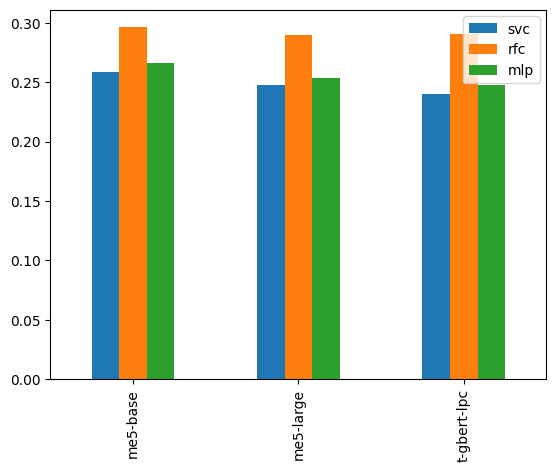

,svc,rfc,mlp
me5-base,0.258669,0.296231,0.266316
me5-large,0.247571,0.289595,0.253733
t-gbert-lpc,0.239921,0.290252,0.247654


In [8]:
from matplotlib import pyplot as plt

scoring.plot(kind="bar")
plt.show()
scoring